In [1]:
getwd()
if ( is.null(environment()$this_notebook_dir) ) {
    this_notebook_dir <- getwd()
    setwd(paste0(getwd(), '/..'))
}
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/data_transform"

[1] "/mnt/hdd/develop/kaggle/house-prices/R"

In [3]:
source('helpers.R')

kaggle.house$loadLibraries()
data <- kaggle.house$loadData()

df.training <- data$train
df.testing <- data$test

c(nrow(df.training),   nrow(df.testing))
c(length(df.training), length(df.testing))

df.training <- df.training %>% mutate(sale_price_log = log(SalePrice))

[1] 1460 1459

[1] 80 79

In [4]:
source('./utils.R')
kaggle.house$utils$get_char_columns_names(df.training)

[1] "Alley"         "BldgType"      "BsmtCond"      "BsmtExposure" 
 [5] "BsmtFinType1"  "BsmtFinType2"  "BsmtQual"      "CentralAir"   
 [9] "Condition1"    "Condition2"    "Electrical"    "ExterCond"    
[13] "Exterior1st"   "Exterior2nd"   "ExterQual"     "Fence"        
[17] "FireplaceQu"   "Foundation"    "Functional"    "GarageCond"   
[21] "GarageFinish"  "GarageQual"    "GarageType"    "Heating"      
[25] "HeatingQC"     "HouseStyle"    "KitchenQual"   "LandContour"  
[29] "LandSlope"     "LotConfig"     "LotShape"      "MasVnrType"   
[33] "MiscFeature"   "MSZoning"      "Neighborhood"  "PavedDrive"   
[37] "PoolQC"        "RoofMatl"      "RoofStyle"     "SaleCondition"
[41] "SaleType"      "Street"        "Utilities"

In [34]:
source("./transform_vars.R")
source("./test_transform_vars.R")

kaggle.house$na$test_na_fixers(df.training, df.testing)

[1] "run tests ..."
# A tibble: 5 x 4
  BldgType      min      max      avg
     <chr>    <dbl>    <dbl>    <dbl>
1     1Fam 12.03112 12.03112 12.03112
2   2fmCon 11.75587 11.75587 11.75587
3   Duplex 11.82026 11.82026 11.82026
4    Twnhs 11.83138 11.83138 11.83138
5   TwnhsE 12.05641 12.05641 12.05641
# A tibble: 5 x 3
  BldgType      min      max
     <chr>    <dbl>    <dbl>
1     1Fam 12.03112 12.03112
2   2fmCon 11.75587 11.75587
3   Duplex 11.82026 11.82026
4    Twnhs 11.83138 11.83138
5   TwnhsE 12.05641 12.05641


In [283]:
library(knitr)

xxx1 <- function(attrName, newAttrName) {
        
    attrName <- enquo(attrName)
    newAttrName <- enquo(newAttrName)
    
    source("./transform_vars.R")
    
    tran <- kaggle.house$trans$transformatorContainer[[as.character(attrName)[2]]]
    
    x <- df.training %>% group_by(!!attrName) %>% count %>% tableGrob 
    y <- tran(df.training) %>% group_by(!!newAttrName, !!attrName) %>% count %>% tableGrob
    #knitr::kable(list(x, y)) %>% print
    
    x2 <- df.testing %>% group_by(!!attrName) %>% count %>% tableGrob
    y2 <- tran(df.testing) %>% group_by(!!newAttrName, !!attrName) %>% count %>% tableGrob
    #knitr::kable(list(x, y)) %>% print
    grid.arrange(x, y, x2, y2, layout_matrix=rbind(c(1, 2), c(3, 4)))
}


xxx2 <- function(attrName, newAttrName) {
       
    attrName <- enquo(attrName)
    newAttrName <- enquo(newAttrName)
    
    source("./fix_missing_values.R")
    source("./transform_vars.R")
    
    tran <- kaggle.house$trans$transformatorContainer[[as.character(attrName)[2]]]
    naFix <- kaggle.house$na$fixerContainer[[as.character(attrName)[2]]]
    
    x <- df.training %>% group_by(!!attrName) %>% count %>% tableGrob
    y <- tran(naFix(df.training)) %>% group_by(!!newAttrName, !!attrName) %>% count %>% tableGrob 
    #knitr::kable(list(x, y)) %>% print
    
    x2 <- df.testing %>% group_by(!!attrName) %>% count %>% tableGrob 
    y2 <- tran(naFix(df.testing)) %>% group_by(!!newAttrName, !!attrName) %>% count %>% tableGrob 
    #knitr::kable(list(x, y)) %>% print
    grid.arrange(x, y, x2, y2, layout_matrix=rbind(c(1, 2), c(3, 4)))
}

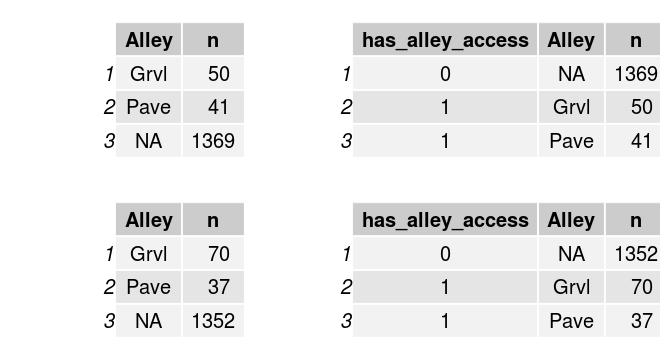

In [284]:
options(repr.plot.width = 5.5, repr.plot.height = 3)
xxx1(Alley, has_alley_access)

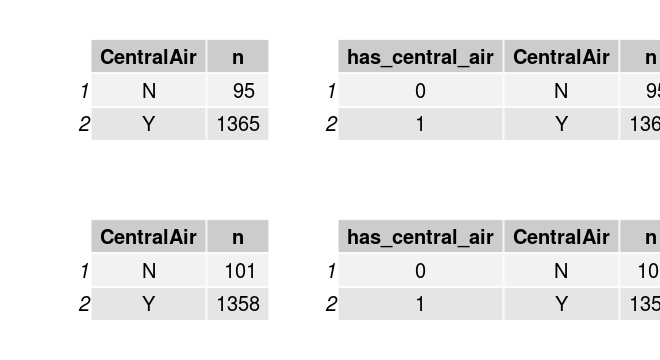

In [285]:
options(repr.plot.width = 5.5, repr.plot.height = 3)
xxx1(CentralAir, has_central_air)

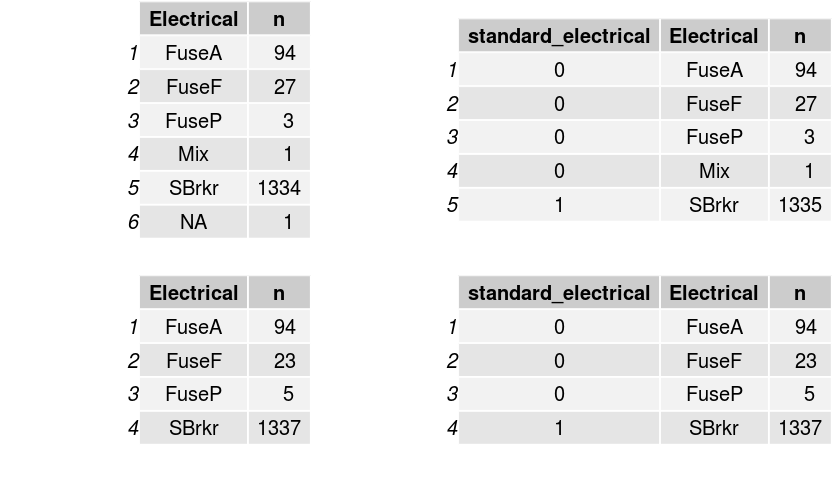

In [274]:
options(repr.plot.width = 7, repr.plot.height = 4)
xxx2(Electrical, standard_electrical)

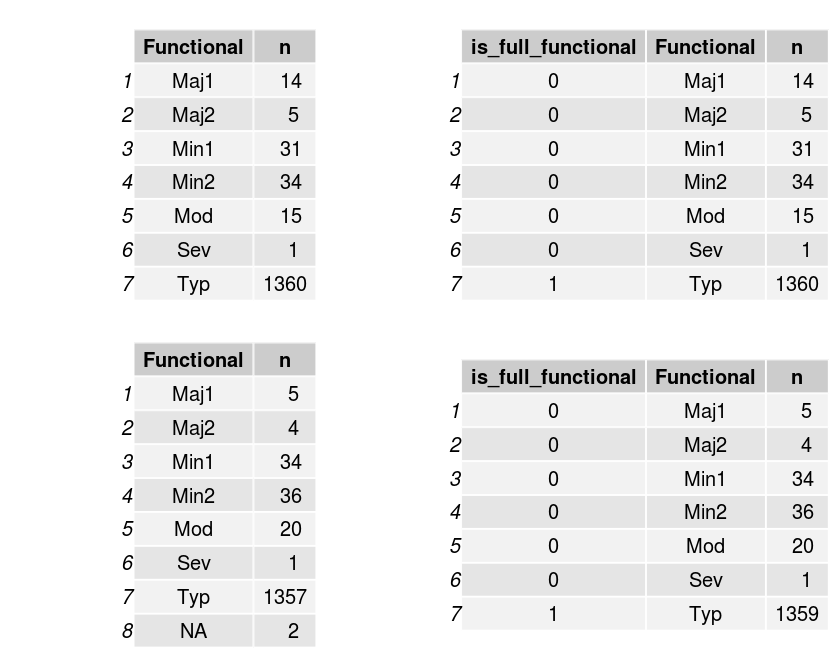

In [281]:
options(repr.plot.width = 7, repr.plot.height = 5.5)
xxx2(Functional, is_full_functional)

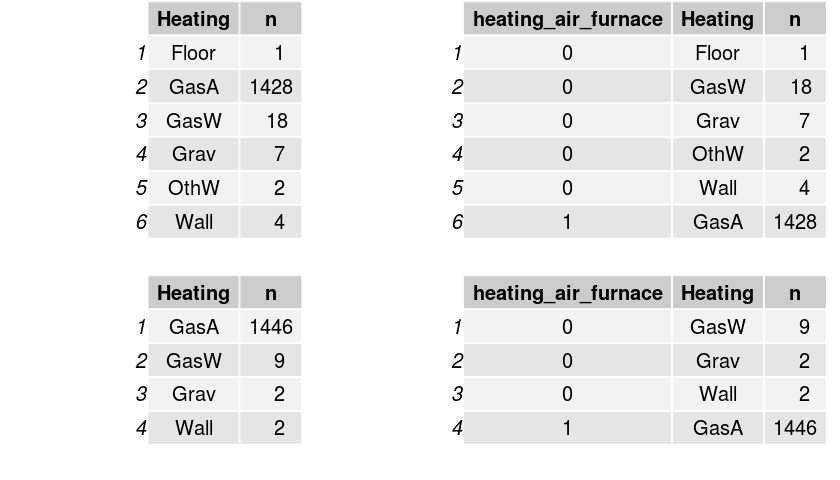

In [288]:
options(repr.plot.width = 7, repr.plot.height = 4)
xxx1(Heating, heating_air_furnace)

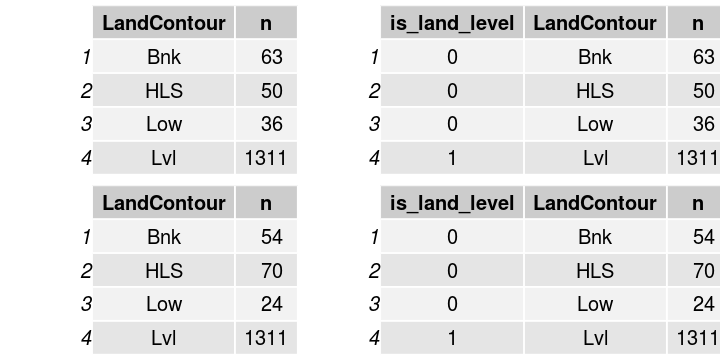

In [291]:
options(repr.plot.width = 6, repr.plot.height = 3)
xxx1(LandContour, is_land_level)

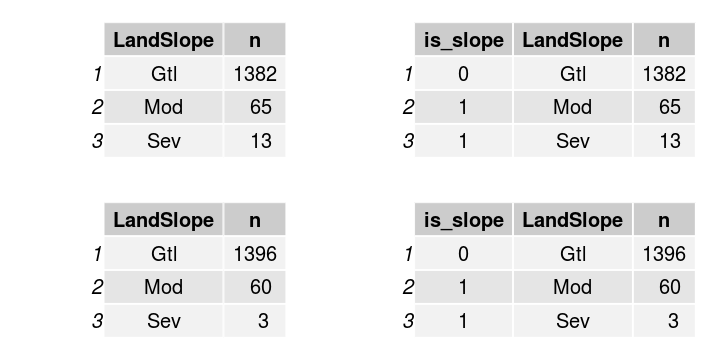

In [292]:
options(repr.plot.width = 6, repr.plot.height = 3)
xxx1(LandSlope, is_slope)

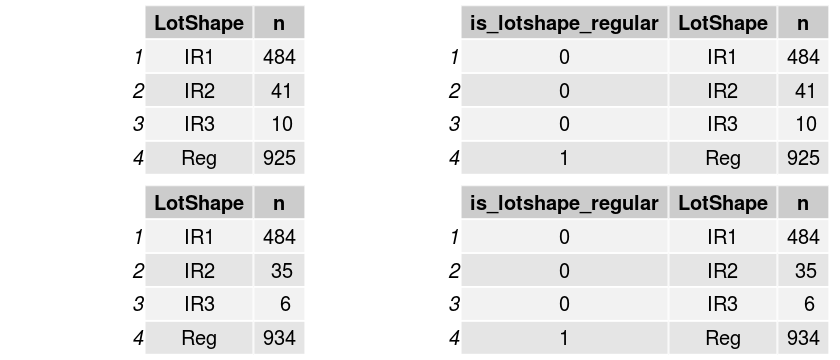

In [294]:
options(repr.plot.width = 7, repr.plot.height = 3)
xxx1(LotShape, is_lotshape_regular)

In [118]:
source("./fix_missing_values.R")
source("./transform_vars.R")
tc <- kaggle.house$trans$transformatorContainer
na <- kaggle.house$na$fixerContainer

df.training %>% group_by(MiscFeature) %>% count
df.training %>% (tc$MiscFeature) %>% group_by(has_misc_feature, MiscFeature) %>% count

df.testing %>% group_by(MiscFeature) %>% count
df.testing %>% (tc$MiscFeature) %>% group_by(has_misc_feature, MiscFeature) %>% count

MiscFeature,n
Gar2,2
Othr,2
Shed,49
TenC,1
NA,1406


has_misc_feature,MiscFeature,n
0,NA,1406
1,Gar2,2
1,Othr,2
1,Shed,49
1,TenC,1


MiscFeature,n
Gar2,3
Othr,2
Shed,46
NA,1408


has_misc_feature,MiscFeature,n
0,NA,1408
1,Gar2,3
1,Othr,2
1,Shed,46


In [120]:
source("./fix_missing_values.R")
source("./transform_vars.R")
tc <- kaggle.house$trans$transformatorContainer
na <- kaggle.house$na$fixerContainer

df.training %>% group_by(PavedDrive) %>% count
df.training %>% (tc$PavedDrive) %>% group_by(has_paved_drive, PavedDrive) %>% count

df.testing %>% group_by(PavedDrive) %>% count
df.testing %>% (tc$PavedDrive) %>% group_by(has_paved_drive, PavedDrive) %>% count

PavedDrive,n
N,90
P,30
Y,1340


has_paved_drive,PavedDrive,n
0,N,90
0,P,30
1,Y,1340


PavedDrive,n
N,126
P,32
Y,1301


has_paved_drive,PavedDrive,n
0,N,126
0,P,32
1,Y,1301


In [124]:
source("./fix_missing_values.R")
source("./transform_vars.R")
tc <- kaggle.house$trans$transformatorContainer
na <- kaggle.house$na$fixerContainer

df.training %>% group_by(PoolQC) %>% count
df.training %>% (tc$PoolQC) %>% group_by(has_pool, PoolQC) %>% count

df.testing %>% group_by(PoolQC) %>% count
df.testing %>% (tc$PoolQC) %>% group_by(has_pool, PoolQC) %>% count

PoolQC,n
Ex,2
Fa,2
Gd,3
NA,1453


has_pool,PoolQC,n
0,NA,1453
1,Ex,2
1,Fa,2
1,Gd,3


PoolQC,n
Ex,2
Gd,1
NA,1456


has_pool,PoolQC,n
0,NA,1456
1,Ex,2
1,Gd,1


In [125]:
source("./fix_missing_values.R")
source("./transform_vars.R")
tc <- kaggle.house$trans$transformatorContainer
na <- kaggle.house$na$fixerContainer

df.training %>% group_by(RoofMatl) %>% count
df.training %>% (tc$RoofMatl) %>% group_by(standard_roof_material, RoofMatl) %>% count

df.testing %>% group_by(RoofMatl) %>% count
df.testing %>% (tc$RoofMatl) %>% group_by(standard_roof_material, RoofMatl) %>% count

RoofMatl,n
ClyTile,1
CompShg,1434
Membran,1
Metal,1
Roll,1
Tar&Grv,11
WdShake,5
WdShngl,6


standard_roof_material,RoofMatl,n
0,ClyTile,1
0,Membran,1
0,Metal,1
0,Roll,1
0,Tar&Grv,11
0,WdShake,5
0,WdShngl,6
1,CompShg,1434


RoofMatl,n
CompShg,1442
Tar&Grv,12
WdShake,4
WdShngl,1


standard_roof_material,RoofMatl,n
0,Tar&Grv,12
0,WdShake,4
0,WdShngl,1
1,CompShg,1442


In [127]:
source("./fix_missing_values.R")
source("./transform_vars.R")
tc <- kaggle.house$trans$transformatorContainer
na <- kaggle.house$na$fixerContainer

df.training %>% group_by(Street) %>% count
df.training %>% (tc$Street) %>% group_by(is_street_paved, Street) %>% count

df.testing %>% group_by(Street) %>% count
df.testing %>% (tc$Street) %>% group_by(is_street_paved, Street) %>% count

Street,n
Grvl,6
Pave,1454


is_street_paved,Street,n
0,Grvl,6
1,Pave,1454


Street,n
Grvl,6
Pave,1453


is_street_paved,Street,n
0,Grvl,6
1,Pave,1453


In [137]:
source("./fix_missing_values.R")
source("./transform_vars.R")
tc <- kaggle.house$trans$transformatorContainer
na <- kaggle.house$na$fixerContainer

res <- tc$BldgType(df.training)

res$df.new %>% group_by(BldgType) %>% summarise(min(building_type), max(building_type), median(sale_price_log))
res$testset.transformator(df.testing) %>% group_by(BldgType) %>% summarise(min(building_type), max(building_type))

BldgType,min(building_type),max(building_type),median(sale_price_log)
1Fam,12.03112,12.03112,12.03112
2fmCon,11.75587,11.75587,11.75587
Duplex,11.82026,11.82026,11.82026
Twnhs,11.83138,11.83138,11.83138
TwnhsE,12.05641,12.05641,12.05641


BldgType,min(building_type),max(building_type)
1Fam,12.03112,12.03112
2fmCon,11.75587,11.75587
Duplex,11.82026,11.82026
Twnhs,11.83138,11.83138
TwnhsE,12.05641,12.05641


In [144]:
source("./fix_missing_values.R")
source("./transform_vars.R")
tc <- kaggle.house$trans$transformatorContainer
na <- kaggle.house$na$fixerContainer

res <- tc$BsmtCond(df.training)

res$df.new %>% group_by(BsmtCond) %>% 
    summarise(n(), min(basement_condition), max(basement_condition), median(sale_price_log))
res$testset.transformator(df.testing) %>% group_by(BsmtCond) %>% 
    summarise(n(), min(basement_condition), max(basement_condition))

BsmtCond,n(),min(basement_condition),max(basement_condition),median(sale_price_log)
Fa,45,11.68267,11.68267,11.68267
Gd,65,12.17499,12.17499,12.17499
Po,2,11.06554,11.06554,11.06554
TA,1311,12.01370,12.01370,12.01370
NA,37,11.53077,11.53077,11.53077


BsmtCond,n(),min(basement_condition),max(basement_condition)
Fa,59,11.68267,11.68267
Gd,57,12.17499,12.17499
Po,3,11.06554,11.06554
TA,1295,12.01370,12.01370
NA,45,11.53077,11.53077


In [145]:
source("./fix_missing_values.R")
source("./transform_vars.R")
tc <- kaggle.house$trans$transformatorContainer
na <- kaggle.house$na$fixerContainer

res <- tc$BsmtExposure(df.training)

res$df.new %>% group_by(BsmtExposure) %>% 
    summarise(n(), min(basement_exposure), max(basement_exposure), median(sale_price_log))
res$testset.transformator(df.testing) %>% group_by(BsmtExposure) %>% 
    summarise(n(), min(basement_exposure), max(basement_exposure))

BsmtExposure,n(),min(basement_exposure),max(basement_exposure),median(sale_price_log)
Av,221,12.13270,12.13270,12.13270
Gd,134,12.33256,12.33256,12.33256
Mn,114,12.11413,12.11413,12.11413
No,953,11.94471,11.94471,11.94471
NA,38,11.55216,11.55216,11.55216


BsmtExposure,n(),min(basement_exposure),max(basement_exposure)
Av,197,12.13270,12.13270
Gd,142,12.33256,12.33256
Mn,125,12.11413,12.11413
No,951,11.94471,11.94471
NA,44,11.55216,11.55216


In [146]:
source("./fix_missing_values.R")
source("./transform_vars.R")
tc <- kaggle.house$trans$transformatorContainer
na <- kaggle.house$na$fixerContainer

res <- tc$BsmtFinType1(df.training)

res$df.new %>% group_by(BsmtFinType1) %>% 
    summarise(n(), min(basement_finish1), max(basement_finish1), median(sale_price_log))
res$testset.transformator(df.testing) %>% group_by(BsmtFinType1) %>% 
    summarise(n(), min(basement_finish1), max(basement_finish1))

BsmtFinType1,n(),min(basement_finish1),max(basement_finish1),median(sale_price_log)
ALQ,220,11.91338,11.91338,11.91338
BLQ,148,11.84295,11.84295,11.84295
GLQ,418,12.27256,12.27256,12.27256
LwQ,74,11.84223,11.84223,11.84223
Rec,133,11.86358,11.86358,11.86358
Unf,430,11.99381,11.99381,11.99381
NA,37,11.53077,11.53077,11.53077


BsmtFinType1,n(),min(basement_finish1),max(basement_finish1)
ALQ,209,11.91338,11.91338
BLQ,121,11.84295,11.84295
GLQ,431,12.27256,12.27256
LwQ,80,11.84223,11.84223
Rec,155,11.86358,11.86358
Unf,421,11.99381,11.99381
NA,42,11.53077,11.53077


In [71]:
transform$BsmtFinType2 <- group_averaging_tran(BsmtFinType2, "basement_finish2")

training %>% group_by(BsmtFinType2) %>% count
tranformed <- transform$BsmtFinType2(training, remove=F)

tranformed %>% group_by(BsmtFinType2) %>% 
summarise(min(basement_finish2), max(basement_finish2), median(sale_price_log))

BsmtFinType2,n
ALQ,19
BLQ,33
GLQ,14
LwQ,46
Rec,54
Unf,1256
NA,38


BsmtFinType2,min(basement_finish2),max(basement_finish2),median(sale_price_log)
ALQ,12.07197,12.07197,12.07197
BLQ,11.87060,11.87060,11.87060
GLQ,12.22033,12.22033,12.22033
LwQ,11.94469,11.94469,11.94469
Rec,11.90995,11.90995,11.90995
Unf,12.02575,12.02575,12.02575
NA,11.55216,11.55216,11.55216


In [73]:
transform$BsmtQual <- group_averaging_tran(BsmtQual, "basement_height_quality")

training %>% group_by(BsmtQual) %>% count
tranformed <- transform$BsmtQual(training, remove=F)

tranformed %>% group_by(BsmtQual) %>% 
summarise(min(basement_height_quality), max(basement_height_quality), median(sale_price_log))

BsmtQual,n
Ex,121
Fa,35
Gd,618
TA,649
NA,37


BsmtQual,min(basement_height_quality),max(basement_height_quality),median(sale_price_log)
Ex,12.66981,12.66981,12.66981
Fa,11.62625,11.62625,11.62625
Gd,12.16562,12.16562,12.16562
TA,11.81673,11.81673,11.81673
NA,11.53077,11.53077,11.53077


In [130]:
training %>% group_by(Fence) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$Fence <- group_averaging_tran(Fence, "fence")

tranformed <- transform$Fence(training, remove=F)

tranformed %>% group_by(Fence) %>% 
summarise(min(fence), max(fence), median(sale_price_log))

Fence,n,avg_price
GdPrv,59,12.02874
GdWo,54,11.84043
MnPrv,157,11.83102
MnWw,11,11.77529
NA,1179,12.06105


Fence,min(fence),max(fence),median(sale_price_log)
GdPrv,12.02874,12.02874,12.02874
GdWo,11.84043,11.84043,11.84043
MnPrv,11.83102,11.83102,11.83102
MnWw,11.77529,11.77529,11.77529
NA,12.06105,12.06105,12.06105


In [131]:
training %>% group_by(FireplaceQu) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$FireplaceQu <- group_averaging_tran(FireplaceQu, "fireplace_qual")

tranformed <- transform$FireplaceQu(training, remove=F)

tranformed %>% group_by(FireplaceQu) %>% 
summarise(min(fireplace_qual), max(fireplace_qual), median(sale_price_log))

FireplaceQu,n,avg_price
Ex,24,12.65794
Fa,33,11.97035
Gd,380,12.24023
Po,20,11.78658
TA,313,12.14153
NA,690,11.81303


FireplaceQu,min(fireplace_qual),max(fireplace_qual),median(sale_price_log)
Ex,12.65794,12.65794,12.65794
Fa,11.97035,11.97035,11.97035
Gd,12.24023,12.24023,12.24023
Po,11.78658,11.78658,11.78658
TA,12.14153,12.14153,12.14153
NA,11.81303,11.81303,11.81303


In [135]:
training %>% group_by(Foundation) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$Foundation <- group_averaging_tran(Foundation, "foundation")

tranformed <- transform$Foundation(training, remove=F)

tranformed %>% group_by(Foundation) %>% 
summarise(min(foundation), max(foundation), median(sale_price_log))

Foundation,n,avg_price
BrkTil,146,11.73807
CBlock,634,11.86005
PConc,647,12.23077
Slab,24,11.55333
Stone,6,11.74454
Wood,3,12.00762


Foundation,min(foundation),max(foundation),median(sale_price_log)
BrkTil,11.73807,11.73807,11.73807
CBlock,11.86005,11.86005,11.86005
PConc,12.23077,12.23077,12.23077
Slab,11.55333,11.55333,11.55333
Stone,11.74454,11.74454,11.74454
Wood,12.00762,12.00762,12.00762


In [145]:
training %>% group_by(GarageFinish) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$GarageFinish <- group_averaging_tran(GarageFinish, "garage_finish")

tranformed <- transform$GarageFinish(training, remove=F)

tranformed %>% group_by(GarageFinish) %>% 
summarise(min(garage_finish), max(garage_finish), median(sale_price_log))

GarageFinish,n,avg_price
Fin,352,12.27839
RFn,422,12.15478
Unf,605,11.81303
NA,81,11.51293


GarageFinish,min(garage_finish),max(garage_finish),median(sale_price_log)
Fin,12.27839,12.27839,12.27839
RFn,12.15478,12.15478,12.15478
Unf,11.81303,11.81303,11.81303
NA,11.51293,11.51293,11.51293


In [148]:
training %>% group_by(GarageType) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$GarageType <- group_averaging_tran(GarageType, "garage_type")

tranformed <- transform$GarageType(training, remove=F)

tranformed %>% group_by(GarageType) %>% 
summarise(min(garage_type), max(garage_type), median(sale_price_log))

GarageType,n,avg_price
2Types,6,11.97505
Attchd,870,12.12811
Basment,19,11.90497
BuiltIn,88,12.33485
CarPort,9,11.58989
Detchd,387,11.77144
NA,81,11.51293


GarageType,min(garage_type),max(garage_type),median(sale_price_log)
2Types,11.97505,11.97505,11.97505
Attchd,12.12811,12.12811,12.12811
Basment,11.90497,11.90497,11.90497
BuiltIn,12.33485,12.33485,12.33485
CarPort,11.58989,11.58989,11.58989
Detchd,11.77144,11.77144,11.77144
NA,11.51293,11.51293,11.51293


In [151]:
training %>% group_by(HeatingQC) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$HeatingQC <- group_averaging_tran(HeatingQC, "heating_quality")

tranformed <- transform$HeatingQC(training, remove=F)

tranformed %>% group_by(HeatingQC) %>% 
summarise(min(heating_quality), max(heating_quality), median(sale_price_log))

HeatingQC,n,avg_price
Ex,741,12.17922
Fa,49,11.72400
Gd,241,11.93164
Po,1,11.37366
TA,428,11.81303


HeatingQC,min(heating_quality),max(heating_quality),median(sale_price_log)
Ex,12.17922,12.17922,12.17922
Fa,11.72400,11.72400,11.72400
Gd,11.93164,11.93164,11.93164
Po,11.37366,11.37366,11.37366
TA,11.81303,11.81303,11.81303


In [154]:
training %>% group_by(HouseStyle) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$HouseStyle <- group_averaging_tran(HouseStyle, "house_style")

tranformed <- transform$HouseStyle(training, remove=F)

tranformed %>% group_by(HouseStyle) %>% 
summarise(min(house_style), max(house_style), median(sale_price_log))

HouseStyle,n,avg_price
1.5Fin,154,11.79055
1.5Unf,14,11.61941
1Story,726,11.94956
2.5Fin,8,12.17549
2.5Unf,11,11.80485
2Story,445,12.15478
SFoyer,37,11.82012
SLvl,65,12.01067


HouseStyle,min(house_style),max(house_style),median(sale_price_log)
1.5Fin,11.79055,11.79055,11.79055
1.5Unf,11.61941,11.61941,11.61941
1Story,11.94956,11.94956,11.94956
2.5Fin,12.17549,12.17549,12.17549
2.5Unf,11.80485,11.80485,11.80485
2Story,12.15478,12.15478,12.15478
SFoyer,11.82012,11.82012,11.82012
SLvl,12.01067,12.01067,12.01067


In [157]:
training %>% group_by(KitchenQual) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$KitchenQual <- group_averaging_tran(KitchenQual, "kitchen_qual")

tranformed <- transform$KitchenQual(training, remove=F)

tranformed %>% group_by(KitchenQual) %>% 
summarise(min(kitchen_qual), max(kitchen_qual), median(sale_price_log))

KitchenQual,n,avg_price
Ex,100,12.66586
Fa,39,11.65269
Gd,586,12.21305
TA,735,11.82774


KitchenQual,min(kitchen_qual),max(kitchen_qual),median(sale_price_log)
Ex,12.66586,12.66586,12.66586
Fa,11.65269,11.65269,11.65269
Gd,12.21305,12.21305,12.21305
TA,11.82774,11.82774,11.82774


In [164]:
training %>% group_by(LotConfig) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$LotConfig <- group_averaging_tran(LotConfig, "lot_config")

tranformed <- transform$LotConfig(training, remove=F)

tranformed %>% group_by(LotConfig) %>% 
summarise(min(lot_config), max(lot_config), median(sale_price_log))

LotConfig,n,avg_price
Corner,263,11.98293
CulDSac,94,12.20235
FR2,47,12.01370
FR3,4,12.18131
Inside,1052,11.98104


LotConfig,min(lot_config),max(lot_config),median(sale_price_log)
Corner,11.98293,11.98293,11.98293
CulDSac,12.20235,12.20235,12.20235
FR2,12.01370,12.01370,12.01370
FR3,12.18131,12.18131,12.18131
Inside,11.98104,11.98104,11.98104


In [165]:
setdiff(char_vars_names, transform %>% names) %>% sort

[1] "Condition1"    "Condition2"    "ExterCond"     "Exterior1st"  
 [5] "Exterior2nd"   "ExterQual"     "GarageCond"    "GarageQual"   
 [9] "MasVnrType"    "MSZoning"      "Neighborhood"  "RoofStyle"    
[13] "SaleCondition" "SaleType"      "Utilities"

In [167]:
training %>% group_by(MasVnrType) %>% summarise(n=n(), avg_price=median(sale_price_log))

transform$MasVnrType <- group_averaging_tran(MasVnrType, "masonry_veneer_type")

tranformed <- transform$MasVnrType(training, remove=F)

tranformed %>% group_by(MasVnrType) %>% 
summarise(min(masonry_veneer_type), max(masonry_veneer_type), median(sale_price_log))

MasVnrType,n,avg_price
BrkCmn,15,11.84223
BrkFace,445,12.10625
None,864,11.87060
Stone,128,12.41647
NA,8,12.22229


MasVnrType,min(masonry_veneer_type),max(masonry_veneer_type),median(sale_price_log)
BrkCmn,11.84223,11.84223,11.84223
BrkFace,12.10625,12.10625,12.10625
None,11.87060,11.87060,11.87060
Stone,12.41647,12.41647,12.41647
NA,12.22229,12.22229,12.22229


In [106]:
transform$Condition1.Condition2 <- function (df) {
    training %>% mutate(
        adjacent_railroad = ifelse(Condition1 %in% c('RRAe', 'RRAn', 'RRNe', 'RRNn') | 
                                   Condition2 %in% c('RRAe', 'RRAn', 'RRNe', 'RRNn'),
                                   1, 0),

        adjacent_traffic_street = ifelse(Condition1 %in% c('Artery', 'Feedr') | 
                                   Condition2 %in% c('Artery', 'Feedr'),
                                   1, 0),

        adjacent_positive = ifelse(Condition1 %in% c('PosA', 'PosN') | 
                                   Condition2 %in% c('PosA', 'PosN'),
                                   1, 0)
    )
}

tranformed <- transform$Condition1.Condition2(training)

training %>% group_by(Condition1) %>% summarise(avg = median(sale_price_log), n=n())
training %>% group_by(Condition2) %>% summarise(avg = median(sale_price_log), n=n())

tranformed %>% 
group_by(adjacent_railroad, adjacent_traffic_street, adjacent_positive, Condition1, Condition2) %>% 
count

Condition1,avg,n
Artery,11.69149,48
Feedr,11.84940,81
Norm,12.02275,1260
PosA,12.26106,8
PosN,12.20607,19
RRAe,11.86710,11
RRAn,12.05227,26
RRNe,12.15853,2
RRNn,12.27373,5


Condition2,avg,n
Artery,11.57004,2
Feedr,11.75586,6
Norm,12.00457,1445
PosA,12.69158,1
PosN,12.49388,2
RRAe,12.15478,1
RRAn,11.82704,1
RRNn,11.43533,2


adjacent_railroad,adjacent_traffic_street,adjacent_positive,Condition1,Condition2,n
0,0,0,Norm,Norm,1260
0,0,1,PosA,Norm,8
0,0,1,PosN,Norm,17
0,0,1,PosN,PosN,2
0,1,0,Artery,Artery,2
0,1,0,Artery,Norm,45
0,1,0,Feedr,Feedr,1
0,1,0,Feedr,Norm,76
0,1,1,Artery,PosA,1
1,0,0,RRAe,Norm,11


In [121]:
training %>% group_by(ExterQual, ExterCond) %>% summarise(avg = median(sale_price_log), n=n())

step1 <- function (df) {
    df %>% mutate(
        ExterQualCond = case_when(
            
            ExterQual == 'Ex' & ExterCond %in% c('Ex', 'Gd', 'TA') ~ 'Ex',
            ExterQual == 'Ex' & ExterCond == 'Fa' ~ 'good',
            
            ExterQual == 'Gd' & ExterCond %in% c('Ex', 'Gd', 'TA') ~ 'Gd',
            ExterQual == 'Gd' & ExterCond == 'Fa' ~ 'typical',
            
            ExterQual == 'TA' & ExterCond != 'Po' ~ 'TA',
            ExterQual == 'Fa' & ExterCond != 'Po' ~ 'Fa',
            T ~ 'Po'
        )
    )
}

step2 <- group_averaging_tran(ExterQualCond, "exterior_qual_cond")

transform$ExterQual.ExterCond <- function(df, remove=T) {
    df.new <- step1(df)
    df.new <- step2(df.new, remove=remove)
    if ( remove ) {
        df.new$ExterQual <- NULL
        df.new$ExterQual <- NULL
    }
    df.new
}

tranformed %>% group_by(ExterQualCond) %>%
summarise(min(exterior_qual_cond), max(exterior_qual_cond), median(sale_price_log))

ExterQual,ExterCond,avg,n
Ex,Ex,12.69158,1
Ex,Gd,12.49313,3
Ex,TA,12.83248,48
Fa,Fa,11.01036,6
Fa,TA,11.50104,8
Gd,Gd,12.25486,35
Gd,TA,12.30592,453
TA,Ex,11.83380,2
TA,Fa,11.68462,22
TA,Gd,11.84940,108


ExterQualCond,min(exterior_qual_cond),max(exterior_qual_cond),median(sale_price_log)
Ex,12.80655,12.80655,12.80655
Fa,11.31751,11.31751,11.31751
Gd,12.30138,12.30138,12.30138
Po,11.24505,11.24505,11.24505
TA,11.84582,11.84582,11.84582
